In [1]:
#import all the libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Importing RFE and LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

# Supress Warnings
#Enable autocomplete in Jupyter Notebook.
%config IPCompleter.greedy=True

import warnings
warnings.filterwarnings('ignore')
import os

### Set seaborn style
sns.set(style="darkgrid")

## Set the max display columns to None so that pandas doesn't sandwich the output 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

#### Helper Functions
Below are a few helper functions that we will use extensively in our notebook. These have been moved to the top to prevent the flow of our analysis.

In [2]:
### Let us create a utility function to generate a list of null values in different dataframes
### We will utilize this function extensively througout the notebook. 
def generateNullValuesPercentageTable(dataframe):
    totalNullValues = dataframe.isnull().sum().sort_values(ascending=False)
    percentageOfNullValues = round((dataframe.isnull().sum()*100/len(dataframe)).sort_values(ascending=False),2)
    columnNamesWithPrcntgOfNullValues = pd.concat([totalNullValues, percentageOfNullValues], axis=1, keys=['Total Null Values', 'Percentage of Null Values'])
    return columnNamesWithPrcntgOfNullValues

In [3]:
### let us create a reuseable function that will help us in ploting our barplots for analysis

def generateBarPlot(dataframe, keyVariable, plotSize):
    fig, axs = plt.subplots(figsize = plotSize)
    plt.xticks(rotation = 90)
    ax = sns.countplot(x=keyVariable, data=dataframe)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/len(dataframe) * 100),
                ha="center") 

In [23]:
### Let us define a reusable function to carry out Bivariate analysis as well.

def generateBiplot(df,col,title,figsize,hue=None):
    
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    plt.figure(figsize=figsize)
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,
                       palette='magma')
    
    convertcount=df.pivot_table(values='SalePrice',index=col,columns='SalePrice', aggfunc='count').fillna(0)
    convertcount["Conversion(%)"] =round(convertcount[1]/(convertcount[0]+convertcount[1]),2)*100
    return print(convertcount.sort_values(ascending=False,by="Conversion(%)"),plt.show())
        
    plt.show()

In [5]:
### Function to generate heatmaps

def generateHeatmaps(df, figsize):
    plt.figure(figsize = figsize)        # Size of the figure
    sns.heatmap(df.corr(),annot = True, annot_kws={"fontsize":7})


In [6]:
### Function to generate ROC curves
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [7]:
### Let us create a reusable function to calculate VIF values for our models

def vifCalculator(inputModel):
    vif= pd.DataFrame()
    X = inputModel
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif


### Importing Data & Checking 

In [8]:
housingDataSet = pd.read_csv("./train.csv")
housingDataSet.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 1. Data Analysis and EDA
We will carry out some exploratory data analysis and understand the data better.

Steps taken:
-    Checking the shape, columns, datatypes etc. of the dataset
-    Assessing out of place values
-    Checking for duplicate values
-    Checking for null values
-    Dropping unnecessary columns
After this basic analysis we will carry out analysis of columns on individual basis and make a decision based on:

In [9]:
housingDataSet.shape

(1460, 81)

In [10]:
housingDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
housingDataSet.describe(percentiles=[0.15,0.35,0.55,0.75,0.95])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
15%,219.850000,20.000000,50.000000,6120.000000,5.000000,5.000000,1936.000000,1955.000000,0.000000,0.000000,0.000000,121.850000,701.700000,804.000000,0.000000,0.000000,988.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1953.000000,1.000000,272.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2006.000000,115000.000000
35%,511.650000,20.000000,60.000000,8450.000000,5.000000,5.000000,1961.000000,1976.000000,0.000000,56.650000,0.000000,320.650000,864.000000,959.650000,0.000000,0.000000,1262.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,6.000000,0.000000,1968.000000,2.000000,412.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,141000.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
55%,803.450000,60.000000,70.000000,9794.500000,6.000000,5.000000,1977.000000,1996.000000,0.000000,450.000000,0.000000,544.000000,1040.000000,1132.450000,0.000000,0.000000,1509.450000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,7.000000,1.000000,1988.000000,2.000000,490.000000,63.450000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,172500.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
95%,1387.050000,160.000000,107.000000,17401.1500

#### Observation

Based on our basic exploration we can say that:

- The shape of the dataset is 1460 columns & 81 rows
- There are a few outliers in this dataset in various numerical columns. For example: LotFrontage, LotArea etc. 
- We have 43 object type columns which we will treat as categorical columns. 
- we have 38 numerical columns.

In [12]:
### Checking for null values

generateNullValuesPercentageTable(housingDataSet)

,Total Null Values,Percentage of Null Values
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
...,...,...
CentralAir,0,0.00
SaleCondition,0,0.00
Heating,0,0.00
TotalBsmtSF,0,0.00


### Observation

There are a lot of columns with high percentage of null values. From the data dictionary we know that these can be treated as missing features. We shall do some further analysis before we impute these with any values. 


Let us individually assess the categorical and continuous columns through univariate, bivariate and multivariate analysis methods.

#### Categorical Columns


### MSZoning

In [35]:
housingDataSet.MSZoning.describe()

count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

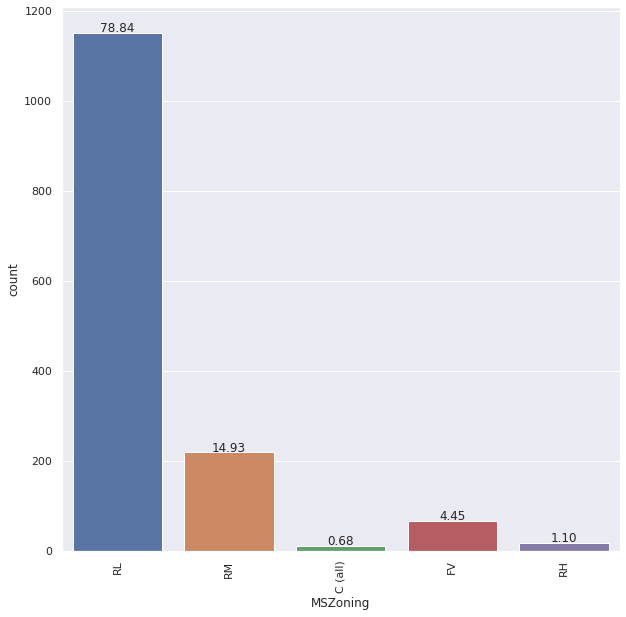

In [19]:
generateBarPlot(housingDataSet, 'MSZoning', (10,10))

### Observation

We can see from the barplot above that:

- 78.84% of the people live in the Residential Low Density zones
- Only 0.68% of the people live in Commercial zones
- We can consider binning the other categories as one because they form a fairly low percentage overall of the feature defined.

### Street

In [36]:
housingDataSet.Street.describe()

count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

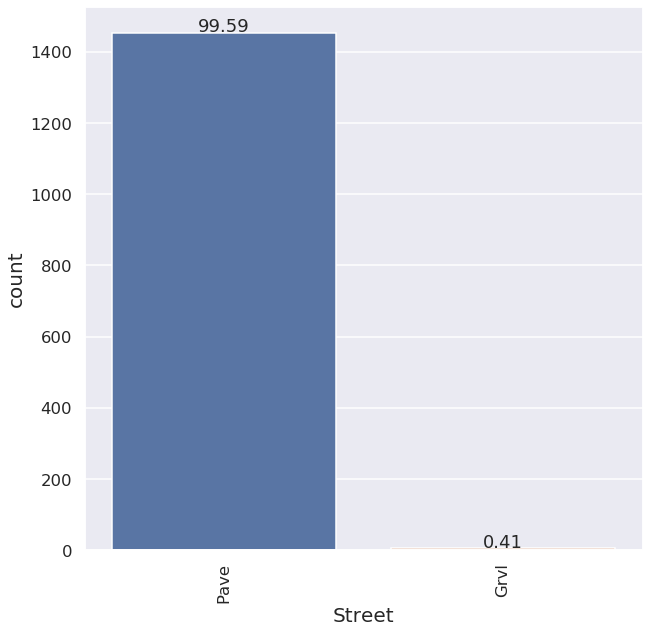

In [25]:
generateBarPlot(housingDataSet, 'Street', (10,10))

### Observation

From the barplot above we can see that the data is highly skewed towards the 'Pave'.

We will drop this column as a highly skewed column has the tendency to skew results. 

We will assess all our columns first before we drop any.

### Alley

In [37]:
housingDataSet.Alley.describe()

count       91
unique       2
top       Grvl
freq        50
Name: Alley, dtype: object

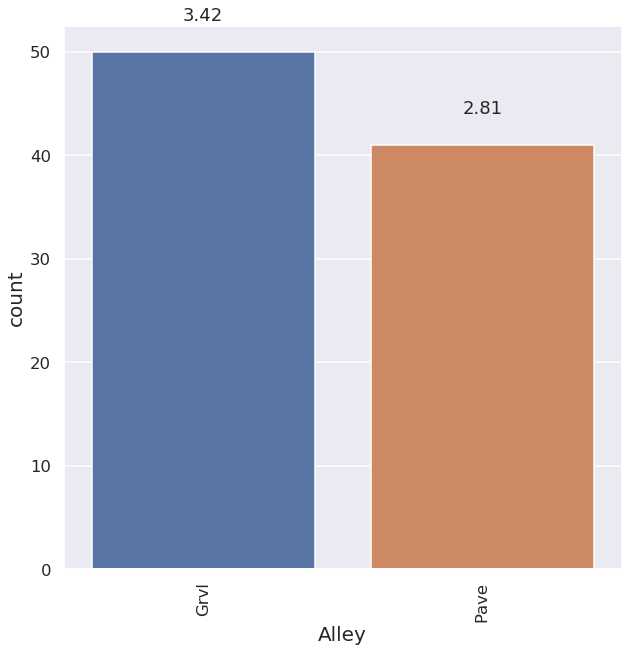

In [33]:
generateBarPlot(housingDataSet, 'Alley', (10,10))

### Observation

From the above barplot we can see that there is a discrepancy in the data. 

From our null value analysis we know that there is are over 90% null values in this column. 

We can therefore confirm that it is safe to drop this column as a whole since it will skew the data again. 

### LotShape

In [38]:
housingDataSet.LotShape.describe()

count     1460
unique       4
top        Reg
freq       925
Name: LotShape, dtype: object

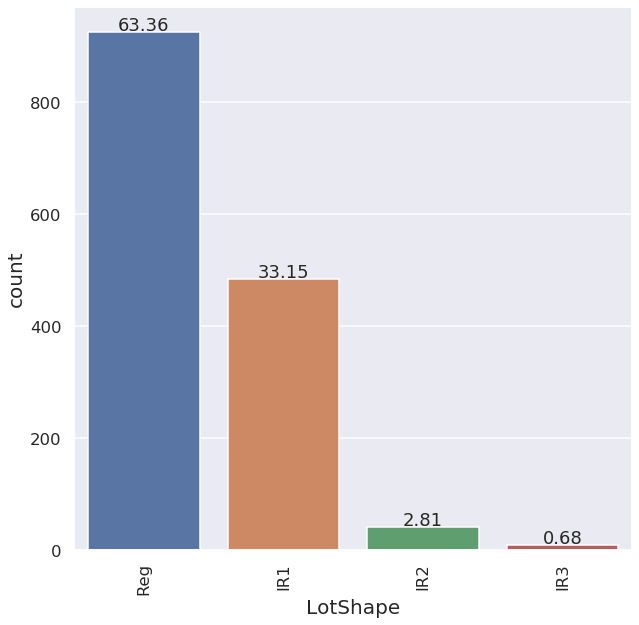

In [34]:
generateBarPlot(housingDataSet, 'LotShape', (10,10))

### Observation

From the barplot above we can see that:

- 63.36% of the people occupy regular shaped properties
- There are no null or missing values as the total of all the %values is 100


### LandContour

In [40]:
housingDataSet.LandContour.describe()

count     1460
unique       4
top        Lvl
freq      1311
Name: LandContour, dtype: object

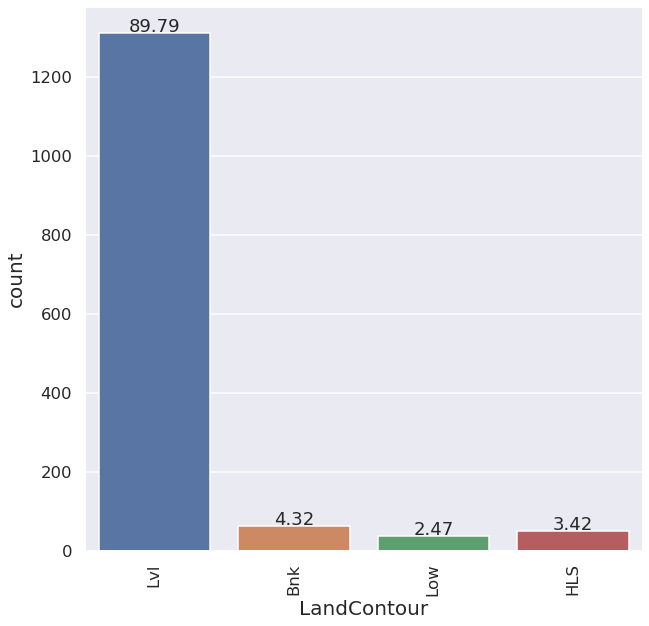

In [39]:
generateBarPlot(housingDataSet, 'LandContour', (10,10))

### Observation

From the barplot above we can see that the data is highly skewed in the Near Flat/Level section. It is safe to drop this variable.

### Utilities

In [41]:
housingDataSet.Utilities.describe()

count       1460
unique         2
top       AllPub
freq        1459
Name: Utilities, dtype: object

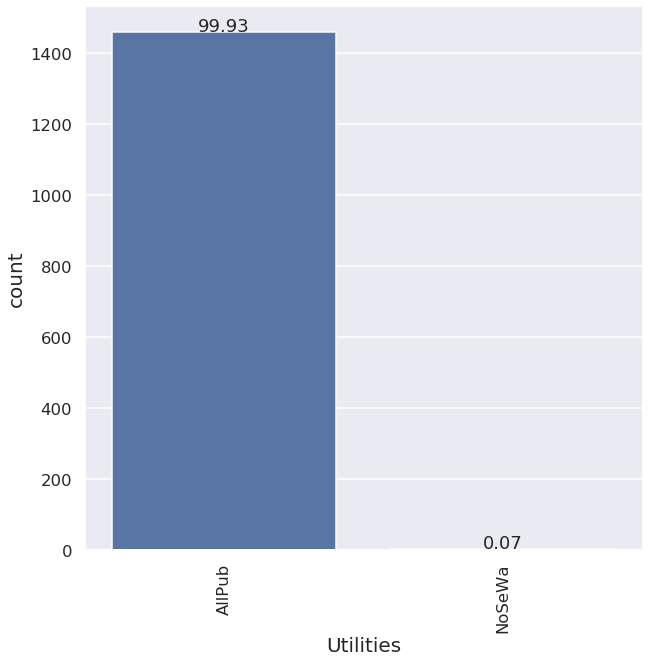

In [42]:
generateBarPlot(housingDataSet, 'Utilities', (10,10))

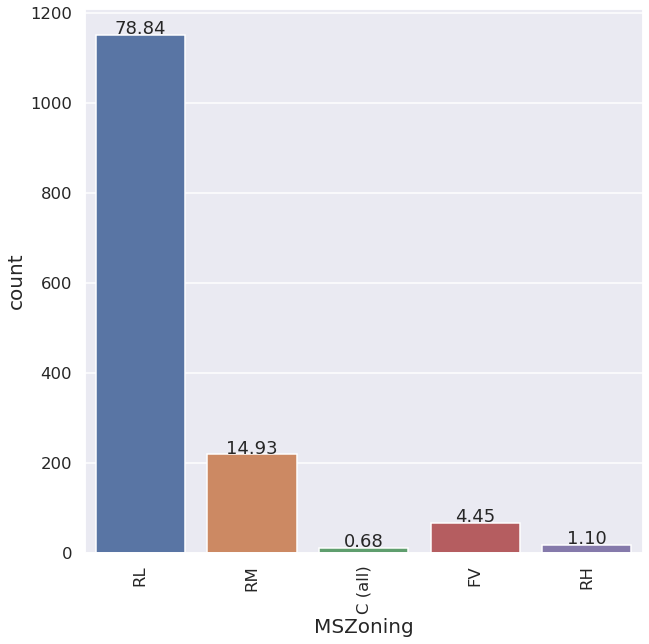

In [30]:
generateBarPlot(housingDataSet, 'LotConfig', (10,10))

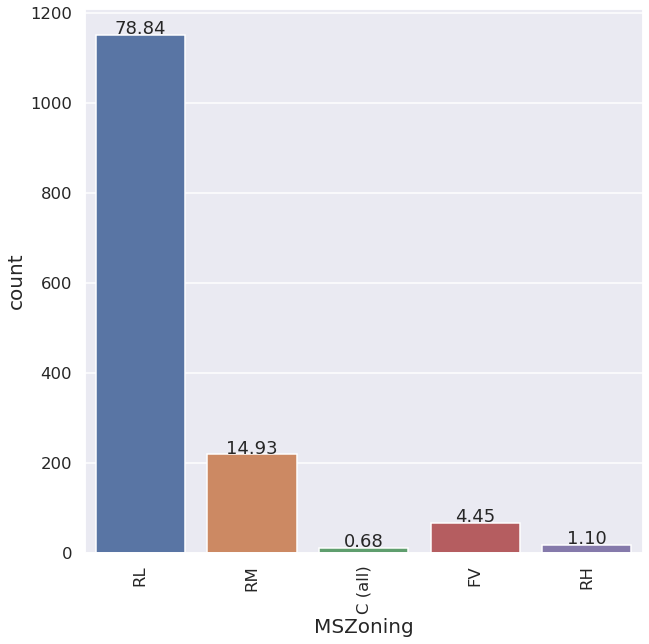

In [31]:
generateBarPlot(housingDataSet, 'LandSlope', (10,10))

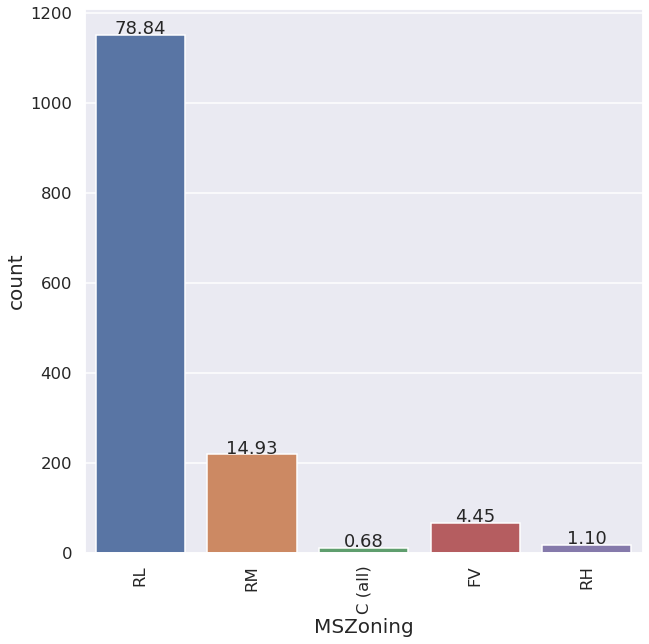

In [32]:
generateBarPlot(housingDataSet, 'Neighborhood', (10,10))

In [ ]:
generateBarPlot(df, 'HouseStyle', (10,10))